# ESS: Analysing and interpreting FDEM data
---
In this notebook you will explore FDEM data in a more in depth way, and relate the outcomes to specific soil properties. Hereby, you will combine geophysical modelling (inversion) with pedophysical modelling, alongside relating specific target properties to the FDEM outcomes in a more stochastic way. 

The first two code cells below are to install required packages in Google Colaboratory, and subsequently import all required packages into the workspace.

In [ ]:
# Install required packages in Google Colaboratory
'''
installs the following packages:
  - emagpy: package to analyse and invert FDEM data
  - pykrige: package to perform geostatistical interpolation (kriging)
  - rasterio: package to handle and manipulate geospatial raster data
'''
!pip install emagpy
!pip install geopandas
!pip install rasterio

In [53]:
# Import packages into workspace
'''
Import the required modules to run all code in this notebook.
'''
# General utility modules
import os
import warnings

# Modules for geopunt data visualisation
from IPython.display import HTML
from IPython.core.display import display
from ipywidgets import widgets, HBox

# Data manipulation and analysis
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.path
from scipy.spatial import cKDTree
import scipy.stats
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem

%matplotlib inline

# Field dataset - Testfield Proefhoeve Bottelaere [Vijverhoek, Oosterzele]
---
The key dataset you will work with in this notebook, is the frequency-domain electromagnetic induction (FDEM) dataset that was collected at our testsite on April 28, 2023. Data were collected with a Dualem-21Sin Beveren (near the port of Antwerp in the north of Belgium), in a poorly draining environment. Based on the soil map, soil texture ranges from sandy loam  to clay. WRB soil groups are Cambisols (Eutric Stagnic Cambisols (Loamic)) and Stagnosols (Dystric Retic Stagnosols (Loamic)), both are generally Ruptic (referring to the occurrence of two different source materials, in this case aeolean sand/loess over Tertiary clay). You can explore the soil map, along with the WRB classification, in the code cell below.

The data you have are collected with a FDEM instrument with the following specifications:
- operating frequency: 9000 Hz
- coil geometries:
    1. three coil pairs in HCP mode with Rx at 0.5 m (HCP0.5), 1.0 m (HCP2.1), 2.0 m (HCP2.0) from Tx.
    2. three coil pairs in PRP mode with Rx at 0.6 m (PRP0.6), 1.1 m (PRP1.1), 2.1 m (PRP2.1) from Tx.
- output: QP data as LIN ECa [mS/m], IP data as field intensity [ppt].

Here you have a line of code that defines a dictionary with the column header names as they occur in the .csv files and dataframes you will use in this notebook: 

`dataset_names = {'HCP0.5':'05mHCP_ECa', 'PRP0.6':'06mPRP_ECa', 'HCP1.0':'1mHCP_ECa', 'PRP1.1':'1mPRP_ECa', 'HCP2.0':'2mHCP_ECa',
       'PRP2.1':'2mPRP_ECa', 'HCP0.5_inph':'05mHCP_IP', 'PRP0.6_inph':'06mPRP_IP', 'HCP1.0_inph':'1mHCP_IP', 'PRP1.1_inph':'1mPRP_IP',
       'HCP2.0_inph':'2mHCP_IP', 'PRP2.1_inph':'2mPRP_IP'}`

Basic processing has been performed, which entails:
- accurate georeferencing and projection to Belge Lambert 1972 coordinate system 
- removal of erroneous datapoints (e.g., standstill moments when the survey setup stopped for >5 seconds)
- drift correction (of all IP and QP/ECa datasets)


In [ ]:
from IPython.display import HTML
from IPython.core.display import display
from ipywidgets import widgets, HBox

airph = '<iframe src="https://www.geopunt.be/embed/d1fa24f5-a258-45b1-887d-8c1f6928a437" width="500" height="600"></iframe>'
soilm = '<iframe src="https://www.geopunt.be/embed/e7d14f05-9d72-4df1-b8ff-4a2b2a9311db" width="500" height="600"></iframe>'

AerialPhoto = widgets.HTML(airph)
SoilMap = widgets.HTML(soilm)

twinbox = HBox([AerialPhoto, SoilMap])
display(twinbox)

# Loading data

In the next code cell, you can load all survey data that was collected during the practicum. These include:
- FDEM_surveydata: full survey dataset of the Bottelare testfield;
- FDEM_transect: extract of the survey dataset along a reference transect. You can use this to test analytical procedures, which you can then deploy across the full survey dataset;
- sampling_data: calibration and validation sample dataset, collected as two independent stratified random sample sets (samples 1 - 10 =  calibration; 11 - 15 =  validation).

The sampling_data dataset includes the x and y coordinates of the samples along with their ID's, and analytical data on:
- bulk density in g/cm^3   (`bd [g/cm3]`);
- porosity [dimensionless]   (`por [-]`);
- clay content in %   (`clay [%]`);
- silt content in %   (`silt [%]`);
- sand content in %   (`sand [%]`);
- total organic carbon in g/kg   (`SOC [g/kg]`);
- soil organic matter in %   (`SOM [%]`);
- hydraprobe soil moisture in %   (`hydra_vmc [%]`)
- hydraprobe soil temperature in C   (`hydra_tmp [C]`)
- hydraprobe raw EC in mS/m   (`hydra_ec [mS/m]`)
- hydraprobe temperature corrected EC in mS/m   (`hydra_ect [mS/m]`)
- hydraprobe soil pore water EC in mS/m   (`hydra_ecp [mS/m]`)
- hydraprobe dielectric permittivity [dimensionless]   (`hydra_er [-]`).

The columnnames are shown between the brackets above. You can use these to access the desired data values in the `ds` dataframe (e.g., for bulk density, the values are in the `ds['bd [g/cm3]]` column).

**All geospatial datasets are provided in Lambert 1972 coordinates** (EPSG:31370).
At any point, if the dataframe structure is unclear, or you want to see the column names, you can use the built-in functions df.head() or df.columns. You can also simply download the .csv files and open these in excel or your preferred software.

In [54]:
# Get dataset location
'''
Create variables with dataset URLs
----------------------------------
FDEM_surveydata: full survey dataset of the Bottelare testfield
FDEM_transect: extract of the survey dataset along a reference transect. You can
                use this to test analytical procedures, which you can then 
                deploy across the full survey dataset
sampling_data: calibration and validation sample dataset (samples 1 - 15)
'''
# store dataset URL's as string variables
FDEM_surveydata = 'https://users.ugent.be/~pjdsmedt/ESS2023/FDEM_2804.csv'
FDEM_transect = 'https://users.ugent.be/~pjdsmedt/ESS2023/FDEM_transect_2804.csv'
#FDEM_transect = 'FDEM_transect_noH.csv'
samples_in = 'https://users.ugent.be/~pjdsmedt/ESS2023/sample_data.csv'
samples = 'https://users.ugent.be/~pjdsmedt/ESS2023/samples_combined.csv'
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create a dictionary of dataset names as above
dataset_names = {'HCP0.5':'05mHCP_ECa', 'PRP0.6':'06mPRP_ECa', 
                'HCP1.0':'1mHCP_ECa', 'PRP1.1':'1mPRP_ECa', 
                'HCP2.0':'2mHCP_ECa', 'PRP2.1':'2mPRP_ECa', 
                'HCP0.5_inph':'05mHCP_IP', 'PRP0.6_inph':'06mPRP_IP', 
                'HCP1.0_inph':'1mHCP_IP', 'PRP1.1_inph':'1mPRP_IP',
                'HCP2.0_inph':'2mHCP_IP', 'PRP2.1_inph':'2mPRP_IP'
                }

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0)
ds = pd.read_csv(samples, sep=',', header=0)
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')

# 0. Data interpolation and exporting

In this notebook, you will work with geospatial data in vector (point) and raster format. To help you along the way to analyse and visualise data, in the following code cell, basic functions to interpolate, export, and manipulate data are given. You can call these functions anywhere in the notebook, as long as you run the following code cell first.

In [4]:
# a. Function to quickly interpolate a scatter dataset to a regular grid.
# -----------------------------------------------------------------------

def interpolate(x, y, z, cell_size, method='nearest', 
                smooth_s = 0, blank=blank):
    """
    Interpolate scatter data to regular grid through selected interpolation 
    method (with scipy.interpolate for simple interpolation).

    Parameters
    ----------
    x : np.array
        Cartesian GPS x-coordinates.

    y : np.array
        Cartesian GPS y-coordinates.

    z : np.array
        Data points to interpolate.

    cell_size : float
        Grid cell size (m).

    method : str, optional
        Scipy interpolation method ('nearest', 'linear', 'cubic' or 'IDW')

    smooth_s : float, optional
        Smoothing factor to apply a Gaussian filter on the interpolated grid.
        If 0, no smoothing is performed. (Applying smoothing can result 
        in a loss of detail in the interpolated grid.)

    blank : object
        A blank object to mask (clip )interpolation beyond survey bounds.

    Returns
    -------
    grid : np.array
        Array of interpolated and masked grid containing:
        - the interpolated grid (grid['grid'])
        - the grid cell size (grid['cell_size'])
        - the grid extent (grid['extent'])

    """

    # Define an evenly spaced grid over which the dataset values have to be 
    # interpolated
    x_min = x.min()
    x_max = x.max() + cell_size
    y_min = y.min()
    y_max = y.max() + cell_size
    x_vector = np.arange(x_min, x_max, cell_size)
    y_vector = np.arange(y_min, y_max, cell_size)
    minx, miny, maxx, maxy = blank.bounds.values.flatten()
    extent = (x_vector[0], x_vector[-1], y_vector[0], y_vector[-1])

    xx, yy = np.meshgrid(x_vector, y_vector)
    nx, ny = xx.shape
    coords = np.concatenate((xx.ravel()[np.newaxis].T, 
                        yy.ravel()[np.newaxis].T), 
                        axis=1)

    # Create a mask to blank grid outside surveyed area
    boolean = np.zeros_like(xx)
    boundaries = np.vstack(blank.loc[0, 'geometry'].exterior.coords.xy).T
    bound = boundaries.copy()
    boolean += matplotlib.path.Path(
        bound).contains_points(coords).reshape((nx, ny))
    boolean = np.where(boolean >= 1, True, False)
    mask = np.where(boolean == False, np.nan, 1)
    binary = np.where(boolean == False, 0, 1)
    
    # Fast (and sloppy) interpolation (scipy.interpolate)
    if method in ['nearest','cubic', 'linear']:
        # Interpolate 
        data_grid = griddata(
            np.vstack((x, y)).T, z, (xx, yy), method=method
            ) * mask
    else:
        print('define interpolation method')
    
    if smooth_s > 0:
        data_grid = gaussian_filter(data_grid, sigma=smooth_s)

    # Create a structured array with additional fields for coordinates and cell size
    dtype = [
        ('grid', data_grid.dtype, data_grid.shape),
        ('cell_size', float),
        ('extent', [
            ('x_min', float), 
            ('x_max', float), 
            ('y_min', float), 
            ('y_max', float)
            ])
    ]
    grid = np.array((data_grid, cell_size, extent), dtype=dtype)
    
    return grid
  

# b. Function to export an interpolated grid to geotif.
# --------------------------------------------------

def export_grid(grid_in, filename='georaster'):
    """
    Interpolate scatter data to regular grid through selected interpolation 
    method (with scipy.interpolate for simple interpolation).

    Parameters
    ----------
    grid_in : np.array
        Array of interpolated and masked grid.

    filename : str, optional
        Name of the GeoTIFF (.tif) file (standard = 'gridded').

    y : np.array
        Cartesian GPS y-coordinates.

    z : np.array
        Data points to interpolate.
    
    """

    #   Get grid properties
    cell_size = grid_in['cell_size']
    extent = grid_in['extent']
    transform = from_origin(extent['x_min'], extent['y_min'], 
                                cell_size, -cell_size)

    #   Prepare rasterio grid
    grid_exp = grid_in['grid']
    grid_exp[np.isnan(grid_exp)] = -99999
    grid_exp = grid_exp.astype(rasterio.float32)
    nx, ny = grid_exp.shape
    grid_exp = np.flip(grid_exp, axis=0)

    
    #   Create an empty grid with correct name and coordinate system
    with rasterio.open(
        filename + '.tif',
        mode='w',
        driver='GTiff',
        height=nx,
        width=ny,
        count=1,
        dtype=str(grid_exp.dtype),
        crs='EPSG:31370', #Lambert 1972 coordinates
        transform=transform,
        nodata=-99999
    ) as dst:
        dst.write(grid_exp, 1)

    # Open the GeoTIFF file in read/write mode to flip the image vertically
    with rasterio.open(filename + '.tif', mode='r+') as dst:
        data = dst.read()
        dst.write(data[0, ::-1], 1)

## Example use of functions

In the following cells, you can use the `interpolate` function to interpolate a single dataset from the FDEM dataset collected on 28.04.2023. The output of this function is a Numpy array that holds the interpolated data (accessed via `datagrid['grid']` in the cell below), alongside the grid's cell size (`datagrid['cell_size']`) and the grid extent (`datagrid['extent']`). The cell size and extent are needed to allow exporting the interpolated data efficiently to a GeoTIF that can be opened in any GIS software such as QGIS. 

Code cell 0.1 below allows interpolating and plotting a single dataset. You can do this for all datasets, by specifying the data column through the `col` variable. 
In code cell 0.2 you can export the interpolated dataset as a geotif for use in your preferred GIS program. You can reuse these functions across the notebook, to interpolate datasets and export generated rasters.
Code cell 0.3 is an example of how you an iteratively interpolate and plot all datasets from the FDEM survey. This provides an overview of all collected ECa and IP datasets.

Take note that the interpolation algorithms implemented here have the primary purpose of quickly visualising data. These are very simple interpolators, from the [SciPy](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html) package, that do not take geostatistical relationship or distances between points into account.

In [ ]:
# 0.1: Example of interpolating and plotting a single FDEM dataset
# ----------------------------------------------------------------

# Specify the data column of which you want to interpolate the values
col = 'HCP1.0'

# Interpolation function
data_grid = interpolate(df['x'], df['y'], df[col], cell_size=0.25)

# --------------------------------------------------------------------

# Specify the grid extent for plotting with correct x-y coordinates
extent = data_grid['extent']

# Set units and colormap (cmap) for either IP or ECa data
if 'inph' in col:
        unit = 'IP [ppt]'
        cmap = 'gray_r'
else:
        unit = 'ECa [mS/m]'
        cmap = 'viridis_r'

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(data_grid['grid'], 
                origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'],
                        extent['y_max']),
                cmap = 'viridis_r'
                )
# Set limits to the plotting range based on data percentiles by 
# uncommenting the 4 lines below: 

# pmin = 2  # lower percentile
# pmax = 98  # upper percentile 
# im.set_clim(np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmin),
#         np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmax))

ax.set_title(f"{col} ({unit})")
plt.colorbar(im, ax=ax)

In [ ]:
# 0.2: Running this cell exports the interpolated dataset as a geotif.
# --------------------------------------------------------------------
"""
You can set the exported file's name by modifying the f_name variable.
In Google Colaboratory, this will be exported to your Google drive, after
which you can download the data locally.
"""

f_name = 'HCP1_ECda' # Filename (.tif suffix is added automatically)
export_grid(data_grid, filename = f_name)

In [ ]:
# 0.3: Example on interpolating and plotting via loop and visualise all datasets
# ------------------------------------------------------------------------------

fig, axes = plt.subplots(4, 3, figsize=(20, 15))

i = 0
data_grids = {}
for col in df.columns:
    # Omit columns that do not contain measurement data
    if col not in ['x','y','z','t']:
        row, col_idx = divmod(i, 3)
        ax = axes[row, col_idx]

        # Set plotting properties for inphase and ECa data
        if '_inph' in col:
            cmap = 'gray_r'
            unit = 'ppt'
        else:
            cmap = 'viridis_r'
            unit = 'mS/m'

        # Interpolate the survey dataset
        data_grid = interpolate(df['x'], df['y'], df[col],
                                        cell_size=0.5)
        extent = data_grid['extent']
        gridplot = data_grid['grid']

        # Visualise the results
        im = ax.imshow(
                        gridplot, 
                        origin='lower', 
                        extent=(extent['x_min'],
                                extent['x_max'],
                                extent['y_min'],
                                extent['y_max']),
                        cmap = cmap
                        )
        ax.set_title(f"{col} ({unit})")
        plt.colorbar(im, ax=ax)
        i += 1
df_data_grids = pd.DataFrame.from_dict(data_grids)
plt.tight_layout()
plt.show()


# 1. FDEM data exploration
### 1.1 Exploring data in QGIS

With the above functions, you are all set to start exploring the FDEM data. If you have exported one or more of the FDEM datasets as geotifs, you can open these in a GIS (instructions here are for [QGIS](https://www.qgis.org/en/site/)]) and compare the observed electromagnetic variations to known soil information.
In QGIS, and create a new project (Ctrl+N, or by using the menus). Set the coordinate reference system to Belgian Lambert 1972 (EPSG:31370).

Raster layers can be added by pressing Ctrl+Shift+R, or navigating to the `Layer > Add Layer > Add Raster Layer` menu item.
You can also add the delimited text file (.csv-file) containing the sample data by pressing Ctrl+Shift+T or navigating to the `Layer > Add Layer > Add Delimited Text Layer` menu item. Make sure that you specific the columns with x- and y- coordinates correctly (X field = `x`; Y field = `y`).

You can add the Flemish soil map to your project by adding the WMS layer. 
Do this by pressing CTRL-Shift-W (or via `Layer>Add Layer>Add WMS/WMTS Layer`). In the popup box you create a new service connection by pressing 'New'. You can enter a name to identify the layer (e.g. 'SoilMap'), and in the URL you copy this address: https://www.dov.vlaanderen.be/geoserver/bodemkaart/bodemtypes/wms?version=1.3.0&request=GetCapabilities&service=wms 

Then press 'Connect' and you should see the different layers in this WMS repository. If you select 1 -- bodemtypes, and Add this (click the button below), you have added the soil map to your project. You can explore the other layers in the WMS as well. Mainly the Digital Soil Map (1) and the drainage class map (2) are relevant for this study. 

The names are indicated in Dutch, but here you have them translated:

1. soil types - Digital Soil Map of the Flemish Region ('bodemtypes')
2. drainage classes (labeled)
3. soil series (labeled)
4. drainage classes (unlabeled)
5. soil series (simplified legend)
6. soil series (contours)
7. soil series (unlabeled)

This way, you can compare the spatial patterning in the geophysical data to the information from the soil map, and to the sample information. You can use this QGIS project to combine and visualise all data from your project.

### 1.2 Evaluating variability in FDEM datasets

Next, you can explore the variability in the FDEM data more quantitatively. In code cell 1.1, you have a function that allows generating the relative sensitivity functions of the deployed coil pairs. This allows you to evaluate at which depth the coil geometry obtains its maximum sensitivity to changes in subsurface electrical conductivity (for the QP (or LIN ECa) response).

In code cell 1.2, you have some plotting functions that allow a first more detailed evaluation of the FDEM datasets. You have a plot of the ECa data collected along the reference transect (dataframe `dt`), alongside a plot of the QP sensitivities of all deployed coil geometries. This provides more detailed insight into the spatial sensitivity of the used configurations, and illustrates at which depths below the surface, most information is gathered with a given coil pair.
In the last plot, the ECa values of the HCP1.0 coil pair are shown at sampling locations 1 - 15. In this scatterplot, the color coding and size of the scatter points are determined by the analytical data obtained at these sampling locations. You can modify the plot parameters to evaluate different relationships and explore the data in more detail. 

To evaluate the data in more detail, you can evaluate the histograms and statistics of the full dataset (dataframe `df`), for which example code is provided in the introductory notebook). 
To investigate the relationships between the observed sensor data (FDEM data) and the analytical data at the sampling locations, you can explore the `ds` dataframe, which holds all analytical information and the nearest sensor observations at each of the 15 sampling locations.

In [5]:
# 1.1: Function to obtain the sensitivity of a given coil geometry
# ----------------------------------------------------------------

def lin_sens(geometry, all=False):
    """
    Calculate approximative cumulative and relative sensitivities based on
    Keller & Frischknecht, 1966 and McNeill, 1980

    Parameters
    ----------
    geometry : str
        coil geometry identifier, combining orientation ('HCP' or 'PRP'),
        and Tx-Rx separation. 'HCP0.5'is thus a HCP orientation with a 0.5 m
        coil separation.

    all : boolean, optional
        if set to true, the function returns the cumulative and relative
        sensitivity of the QP (ECa) and IP response of the evaluated coil pair.
        If set to false, only the relative sensitivity of the QP response is 
        returned.

    Returns
    -------
    rsens_QP : np.array
        Array of relative QP sensitivities obtained over the evaluated depths.
    
    csens_QP : np.array, optional
        Array of cumulative QP sensitivities obtained over the evaluated depths.

    rsens_IP : np.array, optional
        Array of relative IP sensitivities obtained over the evaluated depths.
    
    csens_IP : np.array, optional
        Array of cumulative IP sensitivities obtained over the evaluated depths.

    """
    # determine depth extent along which to evaluate sensitivity
    depths = np.linspace(.0, 2.0, 100)
    sensor_height = 0.165
    if 'inph' in geometry:
        coil_spacing = float(geometry[3:6])
    else: 
        coil_spacing = float(geometry[-3:])

    # create empty arrays
    csens_QP = np.empty_like(depths)
    rsens_QP = np.empty_like(depths)
    csens_IP = np.empty_like(depths)
    rsens_IP = np.empty_like(depths)
    
    depth_ratio = (depths + sensor_height) / coil_spacing
    if 'HCP' in geometry:
        csens_IP = (1 - 8 * depth_ratio ** 2) / ((4 * (depth_ratio ** 2) + 1) ** (5 / 2))
        rsens_IP = 12 * depth_ratio * (3 - 8 * depth_ratio ** 2) / (coil_spacing * ((4 * depth_ratio ** 2) + 1) ** (7 / 2))
        csens_QP = 1 / (4 * (depth_ratio ** 2) + 1) ** 0.5
        rsens_QP = 4 * depth_ratio / (coil_spacing * (4 * depth_ratio ** 2 + 1) ** (3 / 2))

    if 'PRP' in geometry:
        csens_IP = (6 * depth_ratio) / ((4 * (depth_ratio ** 2) + 1) ** 2.5)
        rsens_IP = -(96 * (depth_ratio ** 2) - 6) / (coil_spacing * (4 * (depth_ratio ** 2) + 1) ** (7 / 2))
        csens_QP = 1 - (2 * depth_ratio) / ((4 * depth_ratio ** 2) + 1) ** 0.5
        rsens_QP = 2 / ((coil_spacing * (4 * depth_ratio ** 2) + 1) ** (3 / 2))
    if all:
        return rsens_QP, csens_QP, rsens_IP, csens_IP
    else:
        return rsens_QP

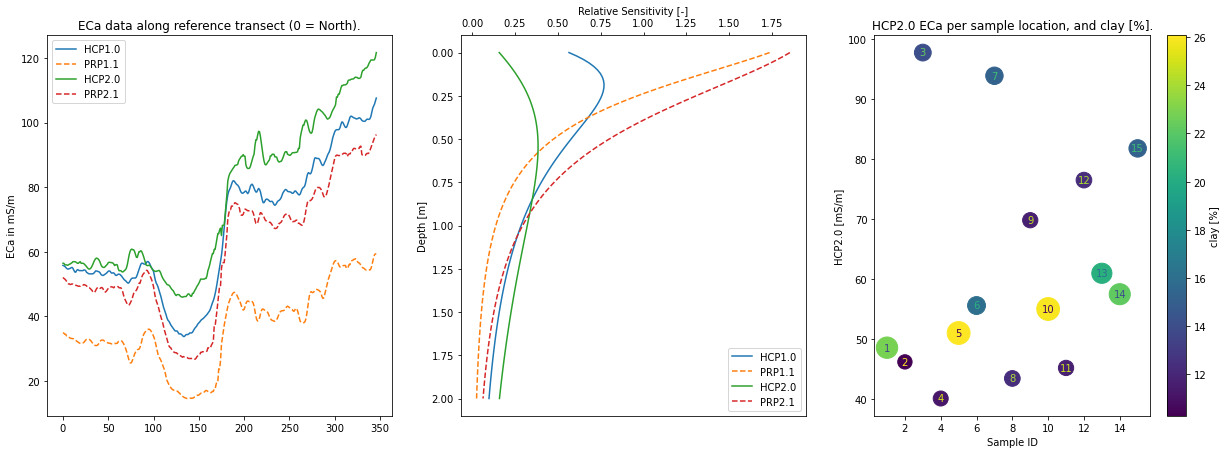

In [6]:
# 1.2: Evaluating FDEM data along the reference transect
# ------------------------------------------------------

"""
Here you can compare plotted ECa data along the reference transect, 
and evaluate these at the sampling locations. In addition, you can 
evaluate the relative sensitivity of the QP (LIN ECa) response of the 
deployed coil configurations. 
------------------------------------------------------------------------
For the third plot, you can evaluate the analytical data at the sampling 
locations (sample_col), and compare these to a selected FDEM dataset (fdem_col)
You can select the desired variables in the two lines of code below this 
comment. You can change these strings to visually evaluate the relationships
# between the analysed properties and the output from different coil pairs.
"""

sample_col = 'clay [%]' # change into, e.g., 'CEC' or 'hydra_ec [mS/m]'
fdem_col = 'HCP1.0' # change into, for instance, 'PRP1.0' or 'HCP1.0_inph'

# ----------------------------------------------------------------------

fig, axes = plt.subplots(1,3, figsize=(21,7))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
for col in dt.columns:
    if col not in ['x','y','z','t','geometry'] and 'inph' not in col:
        if 'PRP' in col:
            ax1.plot(dt[col], linestyle = 'dashed', label = col)
        else:
            ax1.plot(dt[col], label = col)
ax1.set_ylabel('ECa in mS/m')
ax1.set_title('ECa data along reference transect (0 = North).')
ax1.legend()

depths = np.linspace(.0, 2.0, 100)
for col in dt.columns:
    if col not in ['x','y','z','t','geometry'] and 'inph' not in col:
        if 'PRP' in col:
            ax2.plot(lin_sens(col), depths, linestyle = 'dashed', label=col)
        else:
            ax2.plot(lin_sens(col), depths, label=col)

ax2.invert_yaxis()
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Sensitivity [-]')
ax2.set_ylabel('Depth [m]')
ax2.legend()

point_sizes = ds[sample_col] * 20  # Adjust the scaling factor (20) as needed
norm = plt.Normalize(ds[sample_col].min(), ds[sample_col].max())

scatter = ax3.scatter(ds['ID'], ds[fdem_col], 
                        s=point_sizes, c=ds[sample_col], 
                        cmap = 'viridis', norm=norm)
cbar = fig.colorbar(scatter, ax=ax3)
cbar.set_label(sample_col)

ax3.set_xlabel('Sample ID')
if 'inph' in fdem_col:
    ax3.set_ylabel(fdem_col + ' [ppt]')
    ax3.set_title(f'{fdem_col} IP response per sample location, and {sample_col}.')
else:
    ax3.set_ylabel(fdem_col + ' [mS/m]')
    ax3.set_title(f'{fdem_col} ECa per sample location, and {sample_col}.')
inverse_cmap = plt.get_cmap('viridis_r')
# add labels to scatter points showing the sample ID's
for index, row in ds.iterrows():
    text_color = inverse_cmap(norm(row[sample_col]))
    ax3.text(row['ID'], row[fdem_col], str(int(row['ID'])), 
            fontsize=10, ha='center', va='center', color=text_color)

plt.show()

# 2. Exploring relationships between target properties and observed geophysical variations.

To evaluate to which extent the collected FDEM data can help predict the spatial variability of your group's target properties, it is important to understand the relationship between the sensor output, and the targeted properties. This can be done at the sampling locations by further exploring the `ds` dataframe that contains both the FDEM data and analytical data at these locations.
For instance, you can compare the FDEM ECa data to a given property at a given depth, and make the same comparision with the Hydraprobe EC data, as in code cell 2.1.

### 2.1 Stochastic approach
One way to evaluate the relationship between targets and geophysical properties is through a stochastic approach. As an example, regressions are included in code cell 2.1. The linear and polynomial functions are incorporated in the 'lin_fit' and 'poly_fit' objects. You can obtain these functions by simply printing the objects as:

`print(lin_fit)`<br />
`print(poly_fit)`

To extract the slope and intercept from the linear model, you can directly access these as:

`slope = lin_fit[1]` <br />
`intercept = lin_fit[0]`

Suited models, that avoid overfitting and provide satisfactory prediction errors, can then be used to predict the target variable based on the obtained model.

### 2.2 Pedophysical modelling

Pedophysical models are models that aim to describe the relationship between the observed geophysical properties, and the soil properties and states of interest. Generally, a geophysical property of a soil (i.e., a medium that integrates multiple phases) is influenced by the soil constituents (i.e., the relative volumetric proportion of the soil components and their physical properties), and the soil structure (i.e., the spatial distribution of the soil constituents and their interconnection). In class, we have briefly discussed Archie's law, which, when modified for soils, primarily accounts for the conductivity of the pore fluid ($\sigma_{w}$), and considers the degree of saturation $S_{w}$ alongside a saturation exponent n, which relates to the pore structure of the medium. The degree of saturation equals the ratio of the volumetric water content ($\theta$) to the porosity ($\phi$) of the medium:
$$
S_w = \frac{\theta}{\phi}
$$
The combined Archie’s law is:
$$
\sigma = \phi^{m}S_{w}^{n}\sigma_{w}.
$$

This allows estimating the conductivity $\sigma$ for partially saturated media whereby $m$ (fixed at 1.5) and $n$ (fixed at 2) allow including the influence of the medium’s structure.

One major shortcoming of Archie’s law was originally developed for sandy rocks, which presents significant shortcomings when applied to other media such as soils. Most importantly, surface conduction (i.e., the conduction along the surface of dry particles) is not taken into account. In all soils, the influence of surface conductance is non-negligible, and increases with clay content. Other models account for this, such as the adjustment proposed by [Waxman & Smits (1968)](https://users.ugent.be/~pjdsmedt/ESS2023/WS_1986.pdf), and the equation from [Linde et al. 2006](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006WR005131) mentioned in [Romero-Ruiz et al. 2018](http://doi.wiley.com/10.1029/2018RG000611):

$$
\sigma = \phi^{m}S_{w}^{n}\sigma_{w} + (1 - \phi^{m})\sigma_{surface}.
$$

As the surface conductivity is a complex property to quantify, if can estimated based on related soil properties such as the clay content. This approach was taken by [Doussan & Ruy, 2009](http://doi.wiley.com/10.1029/2008WR007309), who related the surface conductivity to soil texture through:

$$
\sigma_{surface} = 0.654\frac{Clay}{Sand+Silt}+0.018,
$$

for soils with a clay content >6%. For soils with a lower clay content, surface conductivity is obtained with:

$$
\sigma_{surface} = 0.023*Clay-0.0209.
$$

In a similar way, the equation of Linde et al. 2006 can be modified to determine surface conductivity based on soil texture, by attributing more weight to a set conductivity of solid particles as the particle size decreases.

You can find both equations as functions below, in code cell 2.2.  
  
**IMPORTANT: In these functions, the electrical conductivities (of bulk soil, pore water, and surface conductivity) are outputted, and have to be inputted, in Siemens per meter (S/m).** This means you have to account for this when inputting values in mS/m, and reading the functions' output. All conductivity data in the datasets you have are presented in mS/m.

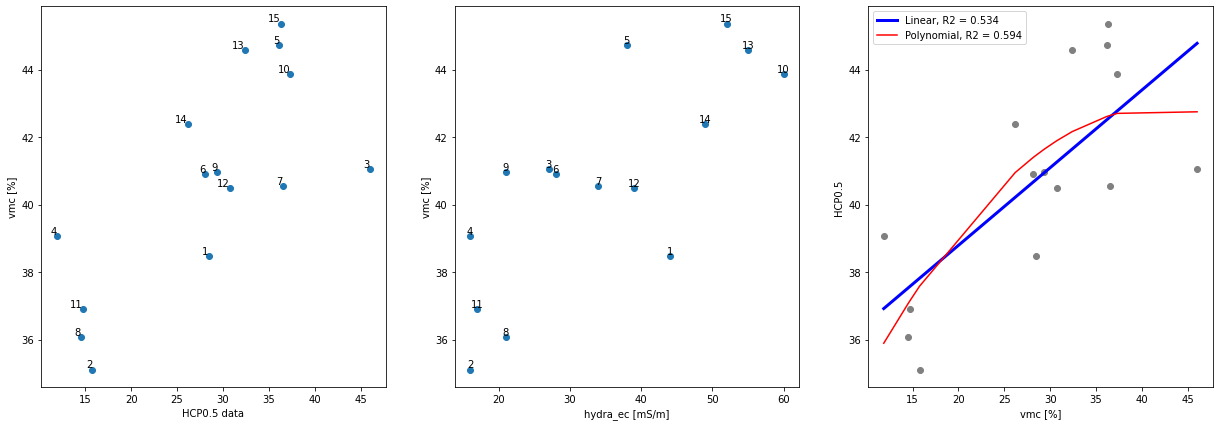

In [13]:
# 2.1: evaluating the relationship between a target property 
# ----------------------------------------------------------

target = 'vmc [%]' # ds columnname for column with target property 
fdem_col = 'HCP0.5' # ds columnname for column with FDEM dataset 
hydra_col = 'hydra_ec [mS/m]' # ds columnname for hydraprobe data column

# set the polynomial degree
poly_degree = 2 # polynomial degree

# ----------------------------------------------------------------------

# create a copy of the sample dataset to plot and, if needed, filter out
# specific points
ds_in = ds.copy()

# uncomment these lines to remove the validation points
# exclude_points = [11,12,13,14,15] # replace with point ID's to remove
# ds_in = ds_in[~ds_in['ID'].isin(exclude_points)]

# -----------------------------------------------------------
# Perform a linear and polynomial regression (cf. notebook 1)
# -----------------------------------------------------------

# 'X' is the input variable of feature
# 'y' is the output variable or 'target'to be predicted

X = ds_in[fdem_col].values.reshape(-1, 1) 
y = ds_in[target].values.reshape(-1, 1) 

sorted_indices = np.argsort(X, axis=0).flatten()
X_sorted = X[sorted_indices]
y_sorted = y[sorted_indices]

# Perform a polynomial regression with Numpy (np)
lin_fit = np.poly1d(np.polyfit(ds_in[fdem_col], ds_in[target], 1))
lin_pred = lin_fit(X_sorted)

# Perform a polynomial regression with Numpy (np)
poly_fit = np.poly1d(np.polyfit(ds_in[fdem_col], ds_in[target], poly_degree))
poly_pred = poly_fit(X_sorted)

# Range over which to evaluate the polynomial for plotting
#x_range = np.linspace(ds_in[fdem_col].min(), ds_in[fdem_col].max(), 100)

y_poly_pred = poly_fit(X_sorted)

# Get the coefficient of determination (R-squared) of the performed regressions
lin_score = r2_score(y_sorted, lin_pred)
ply_score = r2_score(y_sorted, poly_pred)

# -----------------------------------------------------------
# Plotting
# -----------------------------------------------------------

fig, axes = plt.subplots(1,3, figsize=(21,7))
# Define different axes for plotting
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

# First plot
ax1.scatter(ds_in[fdem_col],ds_in[target])
ax1.set_xlabel(f'{fdem_col} data')
ax1.set_ylabel(f'{target}')

# add sample ID labels to the plot
for index, row in ds_in.iterrows():
    ax1.text(row[fdem_col], row[target], str(int(row['ID'])), 
    fontsize=10, ha='right', va='bottom')

# Second plot
ax2.scatter(ds_in[hydra_col],ds_in[target])
ax2.set_xlabel(hydra_col)
ax2.set_ylabel(f'{target}')

#   add sample ID labels to the plot
for index, row in ds_in.iterrows():
    ax2.text(row[hydra_col], row[target], str(int(row['ID'])), 
    fontsize=10, ha='center', va='bottom')

# Third plot
ax3.scatter(X_sorted, y_sorted, color='gray')
ax3.plot(X_sorted, lin_pred, color='blue', linewidth=3, 
            label=f'Linear, R2 = {lin_score:.3f}')
ax3.plot(X_sorted, y_poly_pred, color='red', 
            label=f'Polynomial, R2 = {ply_score:.3f}')
ax3.set_xlabel(target)
ax3.set_ylabel(fdem_col)
ax3.legend()

In [24]:
# 2.2: Pedophysical modelling
# ---------------------------

def doussan_ruy(vmc, bd, clay, water_ec, pdn=2.65, m=1.5, n=2):
    """        
        Parameters
        ----------
        vmc: float
            volumetric water content [-]
        
        bd: float
            bulk density [g/cm3]
        
        clay: float
            Soil volumetric clay content [%]

        water_ec: float
            Soil water real electrical conductivity [S/m]

        pdn: float
            particle density [g/cm3]

        m: float
            cementation exponent [-]

        n: float
            saturation exponent [-]

        Returns
        -------
        bulk_ec: float
            Soil bulk real electrical conductivity [S/m]
    """  
    por = 1-(bd/pdn) # porosity
    sat_w = vmc/por # water saturation
    f_form = por**(-m) # formation factor
 
    if clay > 6:
        surf_ec = (0.654*(clay/(100-clay))) + 0.018 # Surface electrical conductivity
    else:
        surf_ec = 0.023*clay - 0.0209 # Surface electrical conductivity
    
    bulk_ec = ((sat_w**n)/f_form)*(water_ec+(surf_ec/sat_w)) # Soil bulk real electrical conductivity
    return (bulk_ec) 


def linde(vmc, bd, sand, silt, clay, water_ec, pdn=2.65, m=1.5, n=2):
    """        
        Parameters
        ----------
        vmc: float
            volumetric water content [-]
        
        bd: float
            bulk density [g/cm3]
            
        sand: float
            Soil volumetric sand content [%]

        silt: float
            Soil volumetric silt content [%]

        clay: float
            Soil volumetric clay content [%]

        water_ec: float
            Soil water real electrical conductivity [S/m]

        pdn: float
            particle density [g/cm3]

        m: float
            cementation exponent [-]

        n: float
            saturation exponent [-]

        Returns
        -------
        bulk_ec: float
            Soil bulk real electrical conductivity [S/m]
    """  

    por = 1-(bd/pdn) # porosity
    sat_w = vmc/por # water saturation
    f_form = por**(-m) # formation factor

    radius_clay = 0.002/2000
    radius_silt = 0.025/2000
    radius_sand = 0.75/2000

    solid_ec = 1*(10**-7) # Solid electrical conductivity
    clay_ec= 3*(solid_ec/radius_clay)  # clay electrical conductivity
    silt_ec = 3*(solid_ec/radius_silt) # Silt electrical conductivity
    sand_ec = 3*(solid_ec/radius_sand) # Sand electrical conductivity

    surf_ec = np.average([clay_ec*(clay/100), 
                          sand_ec*(sand/100), 
                          silt_ec*(silt/100)])
    bulk_ec = (((sat_w**n)*water_ec) 
               + (f_form - 1)*(surf_ec))/f_form 

    return bulk_ec 

def fu(vmc, bd, clay, water_ec, solid_ec, pdn=2.65, dry_ec=np.nan, sat_ec=np.nan, s=1, w=2):
    """        
        Parameters
        ----------
        vmc: float
            volumetric water content [-]
        
        bd: float
            bulk density [g/cm3]
        clay: float
            Soil volumetric clay content [m**3/m**3]
        water_ec: float
            Soil water real electrical conductivity [S/m]
 
        solid_ec: float
            Soil solid real electrical conductivity [S/m]
        pdn: float
            particle density [g/cm3]
        dry_ec: float
            Soil bulk real electrical conductivity at zero water content [S/m]
        sat_ec: float
            Soil bulk real electrical conductivity at saturation water content [S/m]
        s: float
            phase exponent of the solid [-]
        w: float
            phase exponent of the water [-]
        Returns
        -------
        bulk_ec: float
            Soil bulk real electrical conductivity [S/m]
    """      
    d = 0.6539  # empirical constant
    e = 0.0183  # empirical constant
    por = 1 - bd/pdn   # porosity
    surf_ec = d*clay/(100-clay)+e   # Surface electrical conductivity

    if np.isnan(dry_ec) & np.isnan(sat_ec):
        bulk_ec = solid_ec*(1-por)**s + water_ec*vmc**w + (vmc**(w-1))*(por*surf_ec) # Soil bulk real electrical conductivity

    elif ~(np.isnan(dry_ec)) & ~(np.isnan(sat_ec)):
        bulk_ec = dry_ec + ((dry_ec-sat_ec)/(por**w) - surf_ec)*vmc**w + (vmc**(w-1))*(por*surf_ec) # Soil bulk real electrical conductivity

    elif ~(np.isnan(dry_ec)) & np.isnan(sat_ec):
        sat_ec = dry_ec + (water_ec+surf_ec)*por**w 
        bulk_ec = dry_ec + ((dry_ec-sat_ec)/(por**w) - surf_ec)*vmc**w + (vmc**(w-1))*(por*surf_ec) # Soil bulk real electrical conductivity

    return bulk_ec

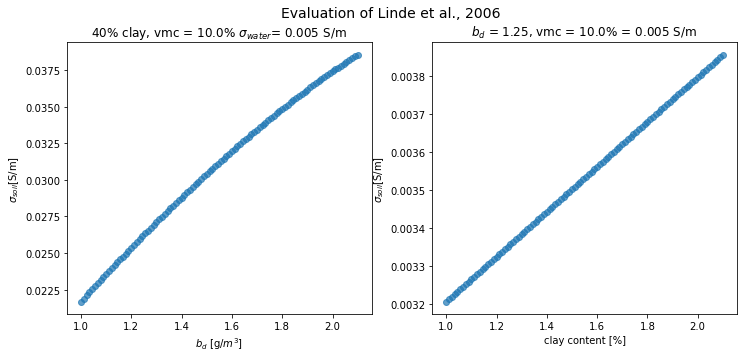

In [14]:
# 2.3: Simple simulation that shows the influence of changing clay content 
# and bulk density on the soil electrical conductivity  (bulk_ec)
# ------------------------------------------------------------------------

"""
Here you can specify if you want to evaluate the Doussan & Ruy (2009)
equation (linde_eq = False); or the Linde et al. (2006) equation (linde_eq
=  False).
You can also set the range of clay content and bulk density to input into the
models, by setting the minimum and maximum values.
"""
# Linde (True) or Doussan & Ruy (False):
linde_eq = True 

# Set minimum and maximum clay content [%] and bulk density [g/cm**3]
min_clay = 8
max_clay = 40
min_clay = 1
max_clay = 2.1

# setting fixed values for vmc, ec_water, clay, and bd as appropriate 
vmc_f = 0.10
ec_water_f = 0.005 #S/m
clay_f = 40
b_dens_f = 1.25

# ----------------------------------------------------------------------

# getting clay and bd range
clay_i = np.linspace(min_clay,max_clay,100)
b_dens_i = np.linspace(1,2.1,100)

# create empty list to populate with iteration results
b_it = []
c_it = []

# iterate over bulk densities
for i in range(100):
    s_in = (100-clay_f)/2
    if linde_eq:
        ec_out=linde(vmc_f, 
                     b_dens_i[i], 
                     s_in, s_in, 
                     clay_f, 
                     ec_water_f)
    else:
        ec_out=doussan_ruy(vmc_f, b_dens_i[i], 
                           s_in, s_in, 
                           clay_f, 
                           ec_water_f)
    
    b_it.append([ec_out,b_dens_i[i]])

# iterate over clay contents
for i in range(100):
    sand_in = (100-clay_i[i])/2
    silt_in = sand_in
    if linde_eq:
        ec_out=linde(vmc_f, b_dens_f,
                            sand_in, silt_in, clay_i[i], 
                            ec_water_f  
                            )
    else:
        ec_out=doussan_ruy(vmc_f, b_dens_f,
                            sand_in, silt_in, clay_i[i], 
                            ec_water_f  
                            )

    c_it.append([ec_out,clay_i[i]])
ec_bd = np.asarray(b_it)
ec_cl = np.asarray(c_it)

if linde_eq:
    title = 'Linde et al., 2006'
else:
    title = 'Doussan & Ruy, 2008'

fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=[12,5])
axes[0].scatter(ec_bd[:,1], ec_bd[:,0],
            alpha=.7)
axes[1].scatter(ec_cl[:,1], ec_cl[:,0],
            alpha=.7)
axes[0].set_xlabel("$b_d$ [g/$m^3$]")
axes[0].set_ylabel("$\sigma_{soil}$[S/m]")
axes[0].set_title(f"{clay_f}% clay, "+ f"vmc = {vmc_f*100}% "+ "$\sigma_{water}$" + f"= {ec_water_f} S/m")
axes[1].set_xlabel("clay content [%]")
axes[1].set_ylabel("$\sigma_{soil}$[S/m]")
axes[1].set_title("$b_d$ = 1.25, " + f"vmc = {vmc_f*100}% "+  f"= {ec_water_f} S/m")
fig.suptitle(f'Evaluation of {title}', fontsize=14)
plt.show()

# 2. FDEM data inversion

Until now, you have worked with raw FDEM data. The QP output of the instrument is given as LIN ECa data, apparent EC data that consider a simple, linear relationship between the subsurface EC, and the QP instrument output. Hereby, the EC of all materials influencing the measurement is considered to be uniform, hence the 'apparent' nature of the data.
  
To evaluate the 'true' conductivity of the subsurface, we have to perform an inversion. In the following code cells, you can perform an inversion on the available FDEM datasets. More specifically, you can invert the ECa data layers collected during the survey, to model the subsurface conductivity. Through this process, you can create vertical sections (across the provided reference transect), and depth slices for specific depth ranges
  
To perform the inversion, we use the open-source EM modelling package [EMagPy](https://pypi.org/project/emagpy/), developed by [McLachlan et al. 2021](https://www.sciencedirect.com/science/article/pii/S0098300420305513). The sources code for this package is available on [GitHub](https://github.com/hkexgroup/emagpy/tree/master/src/emagpy).
  
All inversion procedures are driven by a forward model. As discussed, the forward model allows predicting the response obtained with a specific geophysical instrument used in a specific configuration, given an assumed subsurface model, described by a set of parameters. The underlying model builds on the sensitivities plotted in code block 1.2, only it integrates the cumulative sensitivity (CS) functions that describe how much of the total QP response (or, the ECa) of the instrument can be attributed to EC variations at different depths.
  
These CS functions assume that the sensitivity of the instrument depends only on the depth and the used coil configuration, and is independent of the subsurface EC and the instrument's operating frequency. More comprehensive models can be deployed as well in EMagPy, but these are beyond the scope of this exercise.

In code cell 2.1, you will perform an example inversion along the reference transect. The EMagPy program reads from .csv-files, so the dataset path is the URL that is specified at the beginning of this notebook (stored in the `FDEM_transect` variable). 
You will implement the inversion in a very basic way. The initial parameters you will set are:
- depths0: initial depths in meters of the bottom of each layer to be modelled. The bottom layer boundary is set to infinity (Numpy array with n depths),
- conds0: the initial conductivities in mS/m for each layer (Numpy array with n + 1 conductivities (depth boundary number + 1)).

By loading the .csv files, EMagPy automatically recognises the data columns and coil configurations, and makes use of all ECa datasets to perform the inversion.

All parameters of the inversion have been preset like this:
> `transect.invert(forwardModel='CS', alpha=0.23, njobs=-1)` 

This includes the forward model to use (the cumulative sensitivity), an alpha parameter that smooths the inversion (fixed based on L-curve evaluation), and a parameter to optimize computation (njobs).

In [56]:
# 2.1: Inversion along the reference transect
# -------------------------------------------

# %%capture --no-stdout

# Set the data path
transect_path = FDEM_transect

# Determine the starting model parameters
"""
depths and conductivities are generated with np.arange and np.ones,
alternatively, you can manually create a list of depths 
(e.g., depths = [0.5,0.1]; and conds = [20,40,60], for a 3-layer model with
layer boundaries at 0.5 m and 1.0 m. The first layer has a starting 
conductivity of 20 mS/m, the second of 40 mS/m, and the last of 60 mS/m.)
"""

depths_in = np.arange(0.10, 2, 0.10) #
conds_in = np.ones(depths_in.shape[0]+1)*20 # 

# ----------------------------------------------------------------------

# Create an inversion problem object to solve with EMagPy
transect = Problem()
transect.createSurvey(transect_path, freq=9000,hx=0.165,unit='ECa')
transect.setInit(depths0=depths_in, conds0 = conds_in)

# Run the inversion
transect.invert(forwardModel='CS', alpha=0.23, njobs=-1)
print('   Finished inversion')

  0%|          | 0/347 [00:00<?, ?it/s]

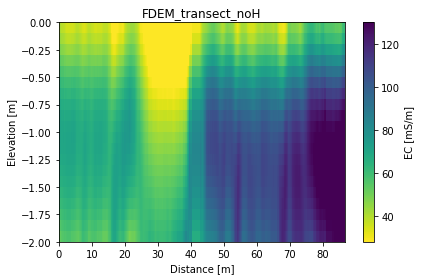

In [10]:
# 2.2: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
transect.showResults(maxDepth= 2, dist=True, errorbar = True) 

# Extracting the values from the first row of the transect.depths[0] array
depth_values = transect.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[transect.surveys[0].df[['x', 'y']].values, transect.models[0]]

# Creating the final dataframe with the desired column names
dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
dt_inv.to_csv('inverted_transect.csv')

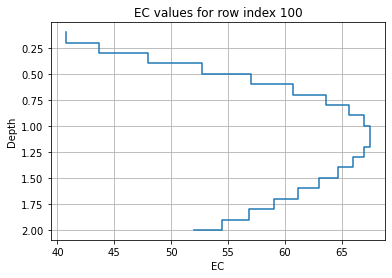

In [11]:
# Plotting a single inverted profile based on its index in the dataframe
# ----------------------------------------------------------------------

# Select the row index for which you want to plot the data
row_index = 100

# Extract the data for the selected row
row_data = dt_inv.loc[row_index, layer_cols].values

# Extract the depth values (excluding the 'EC_end' column)
depth_values = [float(col[3:]) for col in layer_cols[:-1]]

# Add the ending depth value (assuming equal spacing between depth values)
depth_values.append(depth_values[-1] + (depth_values[-1] - depth_values[-2]))

# Create the plot
plt.figure()
plt.step(row_data, depth_values)
plt.xlabel('EC')
plt.ylabel('Depth')
plt.title('EC values for row index {}'.format(row_index))
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

In [ ]:
# 2.3: Inversion at the sampling locations
# -----------------------------------------

# Set the data path
sampling_path = samples

# Determine the inversion parameters (layer boundary depths & conductivities)
'''
Here is an example for a 2 layer model with boundaries at 0.5 and 1 m, amd
starting conductivities of 20, 40 and 60 mS/m. If you adjust the two arrays 
(depths and conds0), you can create your own starting model for the inversion
at the sampling locations.
'''

depths_in = [0.5,1.0] 
conds_in = [20,40,60] # optional

# ----------------------------------------------------------------------
# Create an inversion problem object to solve with EMagPy
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9000,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in, conds0 = conds_in)

# Run the inversion
sample_transect.invert(forwardModel='CS', alpha=0.23, njobs=-1)
print('   Finished inversion')

# Plot inversion outcomes down to a max depth of 1.5 m and plotting the
# results based on the sample sequence in the array (dist = False)
sample_transect.showResults(maxDepth=2, dist=False) 

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = ds.iloc[:, 15:] 

# Append the selected from the sampling dataset to the inversion dataframe
ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)

# ----------------------------------------------------------------------

# Export as a csv-file
ds_all.to_csv('inverted_sample_locs.csv')

### 2.1 Creating EC slices TO DO!!!

After evaluating the outcomes of the inversion conducted in the previous cells, you can apply the inversion to the entire survey dataset. Hereby, you can target specific layers in the subsurface, and model their electrical conductivity. This follows the same flow as in the previous code cells, only now you will not visualise the data along a transect (vertical slice), but you will create horizontal EC slices that represent the electrical conductivities of the layers you define by setting the model depths

In [ ]:
%%capture --no-stdout

# runtime for entire survey when creating 3-layer model ('CS'): 3.5 mins

file_path = FDEM_surveydata
survey = Problem()
survey.createSurvey(file_path, freq=9000,hx=0.165)
survey.setInit(depths0=[0.40, 1.0],
               conds0=[20,40,80],
               fixedDepths=[True,True],
               fixedConds=[False,False,False])
survey.invert(forwardModel='CS',
              method='L-BFGS-B',
              alpha=0.23,njobs=-1)



In [ ]:
# Map conductivity per layer 
survey.showSlice(islice=1, contour=True)
#survey.showSlice(islice=1, contour=True, vmin=0, vmax=120)

In [ ]:
# Put inversion results in dataframe 
# ----------------------------------
# layer_cols = ['EC {:d}'.format(a+1) for a in range(transect.models[0].shape[1])]
# depth_cols = ['depth {:d}'.format(a+1) for a in range(transect.depths[0].shape[1])]
# data = np.c_[transect.surveys[0].df[['x','y']].values, transect.models[0], transect.depths[0]]
# inv_df = pd.DataFrame(data, columns=['x','y'] + layer_cols + depth_cols)
# inv_df.head()

###

# layer_cols = ['EC {:d}'.format(a+1) for a in range(transect.models[0].shape[1])]
# depth_cols = ['depth {:d}'.format(a+1) for a in range(transect.depths[0].shape[1])]
# data = np.c_[transect.surveys[0].df[['x','y']].values, transect.models[0], transect.depths[0]]
# inv_ds = pd.DataFrame(data, columns=['x', 'y'] + layer_cols + depth_cols)


In [ ]:
# islice_n = 1
# survey.showSlice(islice=islice_n, contour=True, vmin=0, vmax=120)
#inv_df.head()
#df.head()
inv_ds.head()